In [1]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
import numpy as np
import os 
import time

from sklearn.model_selection import train_test_split 


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

data = ImageFolder(root="./coin_dataset/coin_dataset", transform=transform)

data_indices = list(range(len(data)))

train_indices, temp_indices = train_test_split(data_indices, test_size=0.2, random_state=42, shuffle=True)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42, shuffle=True)

train_dataset = Subset(data, train_indices)
test_dataset = Subset(data, test_indices)
val_dataset = Subset(data, val_indices)

print(f"Training dataset : {len(train_dataset)}")
print(f"Test dataset : {len(test_dataset)}")
print(f"Validation dataset : {len(val_dataset)}")

data.classes

Training dataset : 4488
Test dataset : 562
Validation dataset : 561


['10cent', '1cent', '20cent', '2cent', '50cent', '5cent']

torch.Size([32, 3, 224, 224])
torch.Size([32])


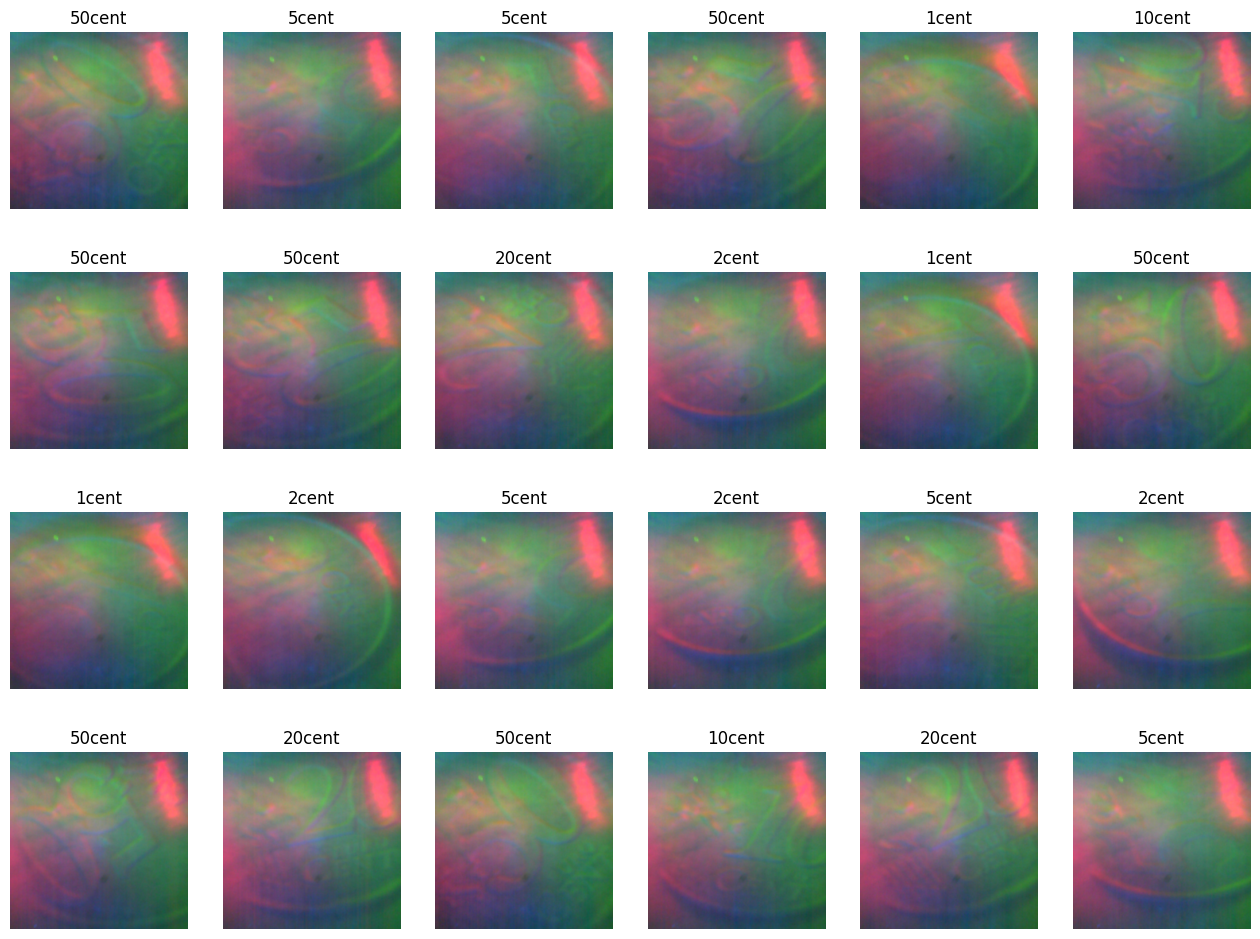

In [17]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

"""
for i in range(10):
    image, label = train_dataset[i]
    print(f"Sample {i + 1}: ")
    print(f"Image : {image.size()}")
    print(f"Label : {label} ({data.classes[label]})")
"""


samples, labels = next(iter(train_loader))
classes = {0:'10cent', 1:'1cent', 2:'20cent', 3:'2cent', 4:'50cent', 5:'5cent'}

print(samples.shape)
print(labels.shape)

fig = plt.figure(figsize=(16, 24))

for i in range(24):
    a = fig.add_subplot(4, 6, i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))

plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)


In [16]:
from transformers import AutoImageProcessor, ResNetForImageClassification
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
import torchvision.models as models
import torch.nn as nn

"""
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")
"""

resnet50 = models.resnet50(pretrained=True)

def set_parameter_require_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.require_grad = False

set_parameter_require_grad(resnet50)

resnet50.fc = nn.Linear(2048, 6)

for param in resnet50.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(resnet50.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(resnet50)
"""
for name, param in resnet50.named_parameters():
    if param.requires_grad:
        print(name, param.data)
"""

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

'\nfor name, param in resnet50.named_parameters():\n    if param.requires_grad:\n        print(name, param.data)\n'

In [18]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(2048, 6)
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [34]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=11, is_train=True):
    
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0.0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss : {:.4f} Acc : {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('../','{0:0=2d}.pth'.format(epoch)))
        print()
    
    time_elapsed = time.time() - since
    
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc : {:4f}'.format(best_acc))
    return acc_history, loss_history



In [35]:
params_to_update = []

for name, param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t", name)

optimizer = optim.Adam(params_to_update)

	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downs

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_lost_hist = train_model(model, train_loader, criterion, optimizer, device)

Epoch 0/10
----------
Loss : 1.8616 Acc : 0.1397

Epoch 1/10
----------
Loss : 1.8616 Acc : 0.1397

Epoch 2/10
----------
Loss : 1.8616 Acc : 0.1397

Epoch 3/10
----------
Loss : 1.8616 Acc : 0.1397

Epoch 4/10
----------
Loss : 1.8616 Acc : 0.1397

Epoch 5/10
----------
Loss : 1.8616 Acc : 0.1397

Epoch 6/10
----------
Loss : 1.8616 Acc : 0.1397

Epoch 7/10
----------
Loss : 1.8616 Acc : 0.1397

Epoch 8/10
----------
Loss : 1.8616 Acc : 0.1397

Epoch 9/10
----------
Loss : 1.8616 Acc : 0.1397

Epoch 10/10
----------
Loss : 1.8616 Acc : 0.1397

Training complete in 31m 42s
Best Acc : 0.139706


In [41]:
import glob

test_loader = DataLoader(test_dataset, batch_size=32, num_workers=1, shuffle=True)

def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('../'+'*.pth')
    saved_models.sort()
    #print('saved_model', saved_models)
    
    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0

            running_corrects += preds.eq(labels.cuda()).int().sum()
        
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elased = time.time()
    print('Validation complete in {:.0f}s'.format(time_elased // 60, time_elased % 60))
    print('Best Acc : {:4f}'.format(best_acc))

    return acc_history


Loading model ../00.pth
Acc: 0.1459

Loading model ../01.pth
Acc: 0.1459

Loading model ../02.pth
Acc: 0.1459

Loading model ../03.pth
Acc: 0.1459

Loading model ../04.pth
Acc: 0.1459

Loading model ../05.pth
Acc: 0.1459

Loading model ../06.pth
Acc: 0.1459

Loading model ../07.pth
Acc: 0.1459

Loading model ../08.pth
Acc: 0.1459

Loading model ../09.pth
Acc: 0.1459

Loading model ../10.pth
Acc: 0.1459

Validation complete in 28911698s
Best Acc : 0.145907
[0.14590747330960854, 0.14590747330960854, 0.14590747330960854, 0.14590747330960854, 0.14590747330960854, 0.14590747330960854, 0.14590747330960854, 0.14590747330960854, 0.14590747330960854, 0.14590747330960854, 0.14590747330960854]


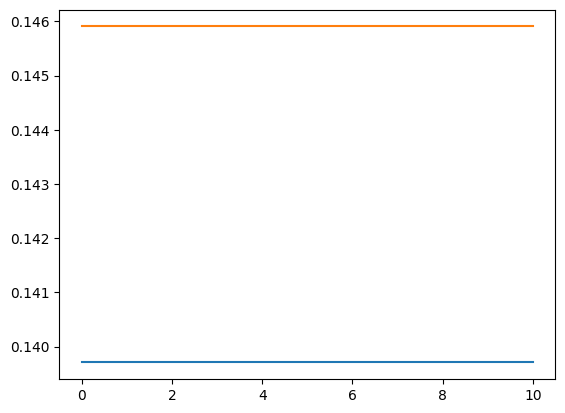

In [43]:
val_acc_hist = eval_model(model, test_loader, device)

print(val_acc_hist)
average_acc = val_acc_hist

plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

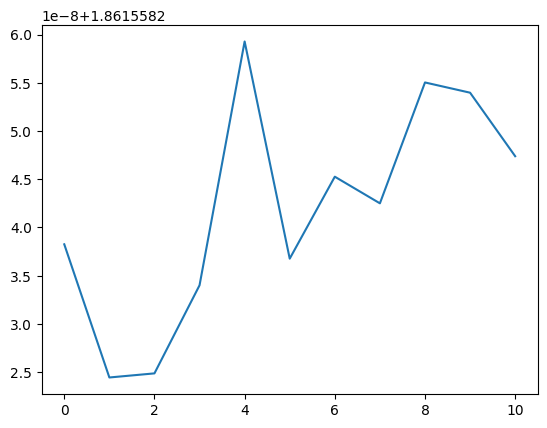

In [44]:
plt.plot(train_lost_hist)
plt.show()

In [51]:
def im_convert(tensor):
    image = tensor.clone().detach().cpu().numpy()
    image = image.transpose(1, 2, 0)
    image = image * (np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)))
    image = image.clip(0, 1)
    return image

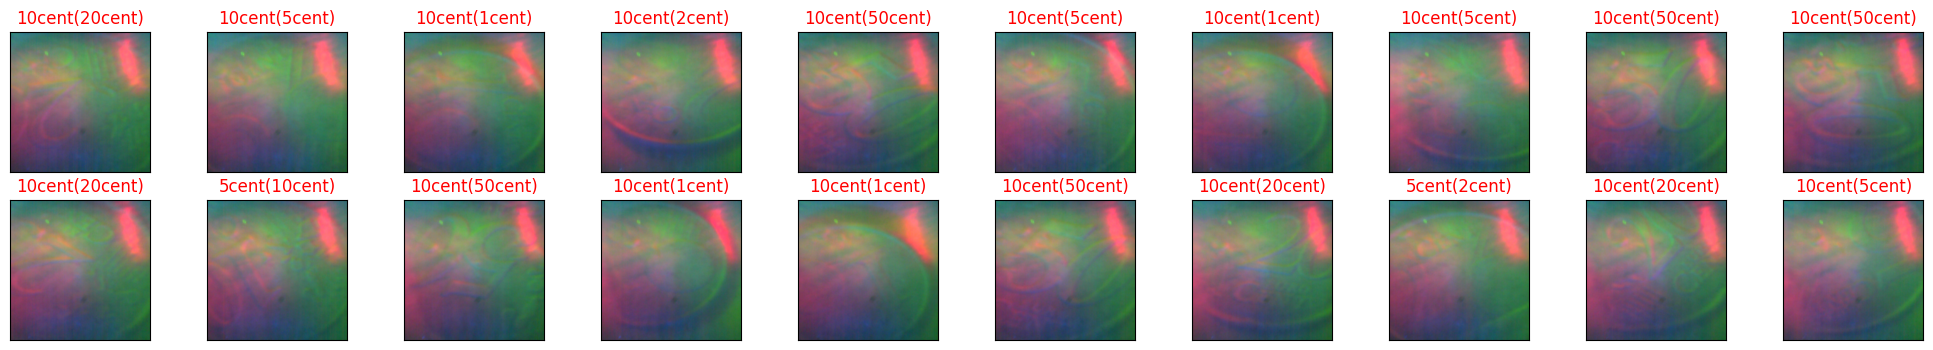

<Figure size 640x480 with 0 Axes>

In [53]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images, labels = images.cuda(), labels.cuda()

output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))

plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

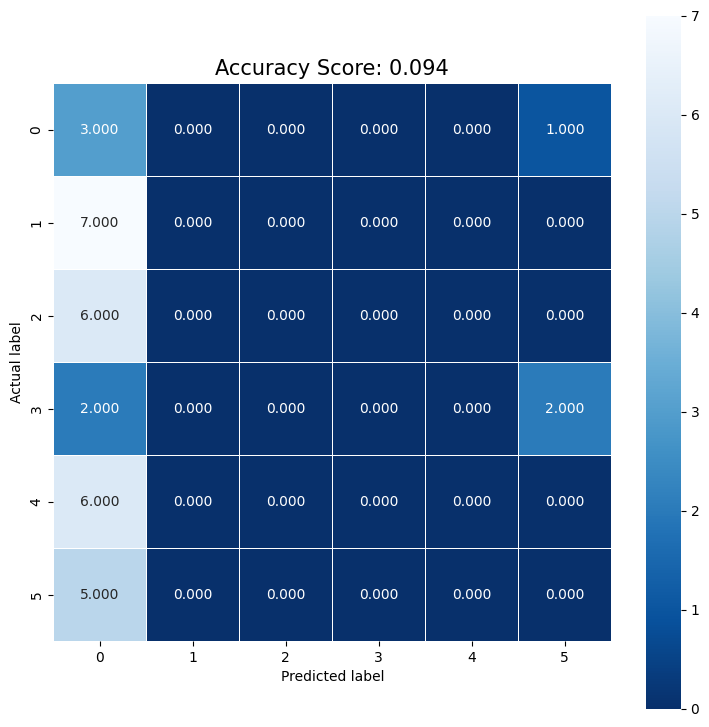

In [57]:
import seaborn as sns
from sklearn import metrics

labels_cpu = labels.cpu().numpy()
preds_cpu = preds.cpu().numpy()

cm = metrics.confusion_matrix(labels_cpu, preds_cpu)

plt.figure(figsize=(9, 9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
plt.ylabel("Actual label")
plt.xlabel('Predicted label')

accuracy = metrics.accuracy_score(labels_cpu, preds_cpu)
all_sample_title = f"Accuracy Score: {accuracy:.3f}"
plt.title(all_sample_title, size=15)
plt.show()